# Object Detection Implementation

This notebook implements the main object detection functionality using YOLO.

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import os

# Load our trained model
model = YOLO("models/yolov8n_object_detector.pt")
print("Model loaded - let's detect some objects!")

Model loaded - let's detect some objects!


In [17]:
class ObjectDetector:
    """A friendly object detector that makes YOLO easy to use"""
    
    def __init__(self, model_path="models/yolov8n_object_detector.pt"):
        self.model = YOLO(model_path)
        self.class_names = self.model.names
        print("Object detector ready to go!")
        
    def detect_objects(self, image_path, confidence_threshold=0.5):
        """
        Find objects in an image - the main detection function
        
        Args:
            image_path: Where to find your image
            confidence_threshold: How sure should we be? (0.5 = 50% sure)
            
        Returns:
            Raw results and a nice image with boxes drawn
        """
        results = self.model(image_path, conf=confidence_threshold)
        annotated_image = results[0].plot()
        
        return results, annotated_image
    
    def get_detection_info(self, results):
        """Extract the important bits from detection results"""
        detections = []
        
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for i in range(len(boxes)):
                    # Package up the detection info nicely
                    detection = {
                        'class_id': int(boxes.cls[i]),
                        'class_name': self.class_names[int(boxes.cls[i])],
                        'confidence': float(boxes.conf[i]),
                        'bbox': boxes.xyxy[i].tolist()  # Box coordinates
                    }
                    detections.append(detection)
        
        return detections

# Create our detector
detector = ObjectDetector()

Object detector ready to go!


In [18]:
def display_results(image_path, results, detections):
    """Show the before and after - original image vs detected objects"""
    
    # Load and prepare images for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    annotated_image = results[0].plot()
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    ax2.imshow(annotated_image)
    ax2.set_title(f"Detected Objects ({len(detections)} found)")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # List what we found
    print("\nWhat did we find?")
    print("-" * 40)
    for i, det in enumerate(detections):
        confidence_percent = det['confidence'] * 100
        print(f"{i+1}. {det['class_name']}: {confidence_percent:.0f}% confident")
    
    if not detections:
        print("No objects detected above confidence threshold.")
        print("Try lowering the confidence threshold or use a different image.")

print("Display function ready")

Display function ready


Testing our object detector...

Processing: created_sample.jpg




image 1/1 /run/media/zain/Local Disk/Projects/Python/object_detection/test_images/created_sample.jpg: 480x640 (no detections), 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)
Speed: 5.0ms preprocess, 11.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


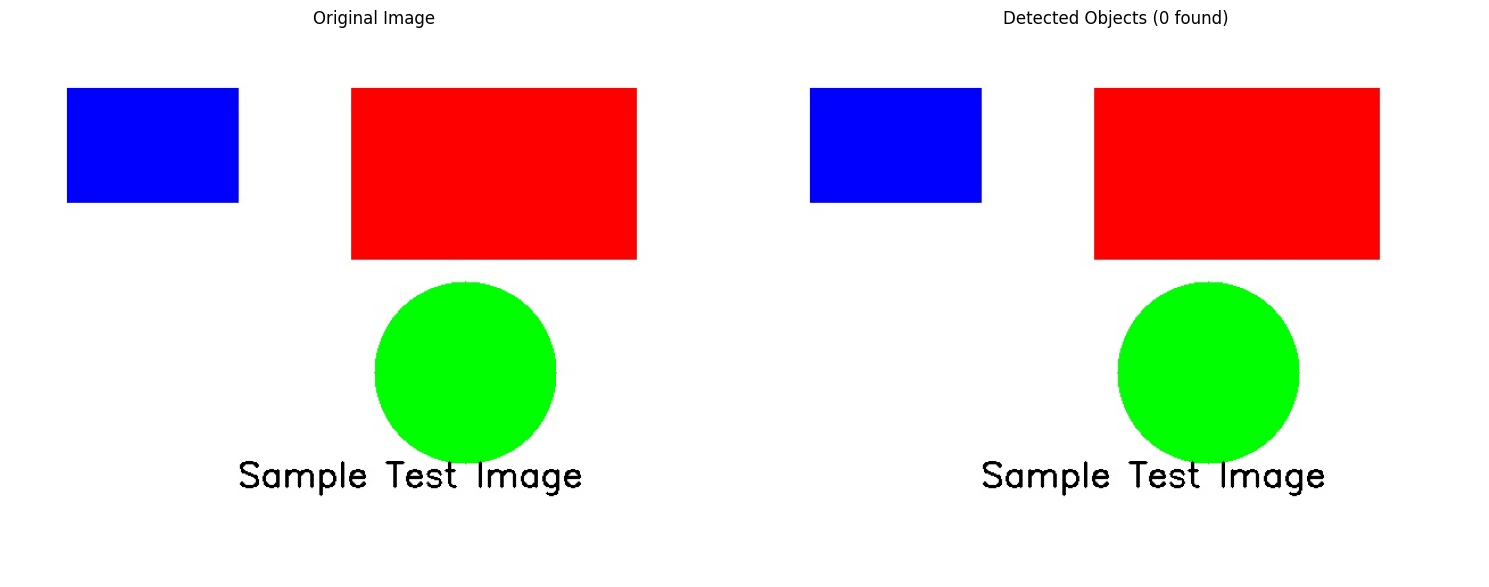


What did we find?
----------------------------------------
No objects detected above confidence threshold.
Try lowering the confidence threshold or use a different image.
Result saved: results/detected_created_sample.jpg

Processing: cycling001-1024x683.jpg

image 1/1 /run/media/zain/Local Disk/Projects/Python/object_detection/test_images/cycling001-1024x683.jpg: 448x640 1 person, 1 bicycle, 1 car, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)
image 1/1 /run/media/zain/Local Disk/Projects/Python/object_detection/test_images/cycling001-1024x683.jpg: 448x640 1 person, 1 bicycle, 1 car, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)


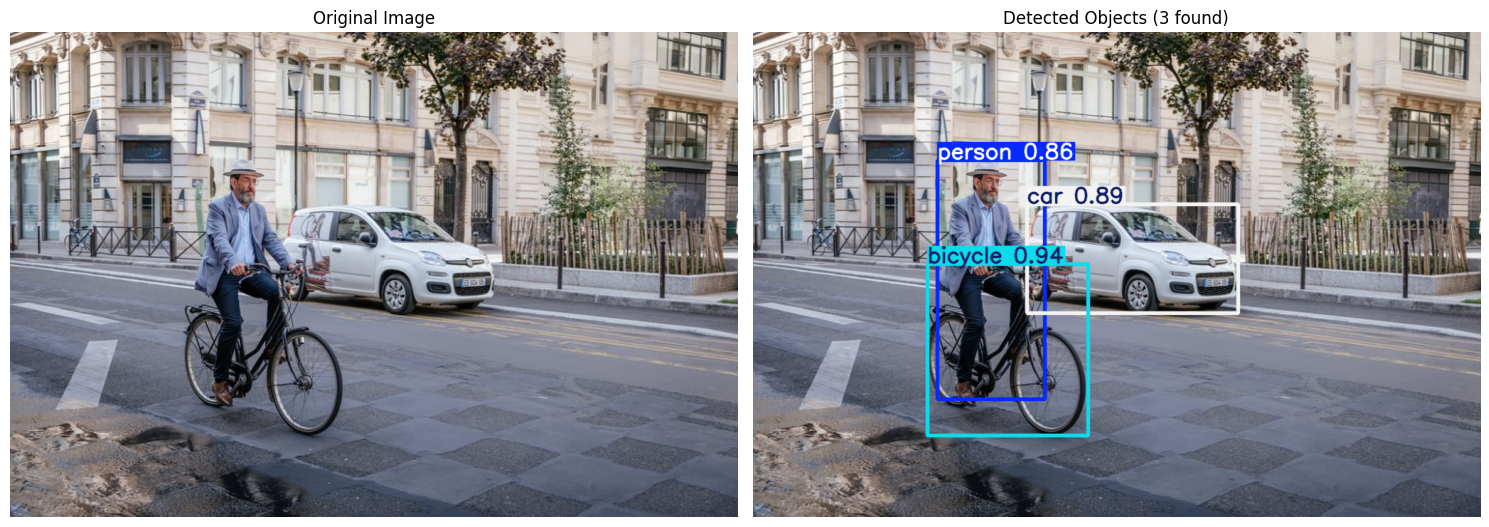


What did we find?
----------------------------------------
1. bicycle: 94% confident
2. car: 89% confident
3. person: 86% confident
Result saved: results/detected_cycling001-1024x683.jpg



In [19]:
# Let's test our detector on the sample images
test_images = [f for f in os.listdir("test_images") if f.endswith(('.jpg', '.png', '.jpeg'))]

print("Testing our object detector...\n")

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

for img_file in test_images[:2]:  # Test first 2 images to keep things manageable
    image_path = f"test_images/{img_file}"
    print(f"Processing: {img_file}")
    
    try:
        # Run the detection
        results, annotated_image = detector.detect_objects(image_path, confidence_threshold=0.5)
        detections = detector.get_detection_info(results)
        
        # Show what we found
        display_results(image_path, results, detections)
        
        # Save the result for later
        result_path = f"results/detected_{img_file}"
        cv2.imwrite(result_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
        print(f"Result saved: {result_path}\n")
        
    except Exception as e:
        print(f"Oops! Error processing {img_file}: {e}\n")

In [20]:
def detect_user_image(image_path, confidence=0.5, save_result=True):
    """
    Easy function to detect objects in any image you provide
    
    Just give it a path to your image and it'll do the rest!
    """
    
    if not os.path.exists(image_path):
        print(f"Hmm, can't find that image: {image_path}")
        print("Double-check the path and try again!")
        return None
    
    try:
        print(f"Analyzing your image: {os.path.basename(image_path)}")
        
        # Do the detection magic
        results, annotated_image = detector.detect_objects(image_path, confidence)
        detections = detector.get_detection_info(results)
        
        # Show the results
        display_results(image_path, results, detections)
        
        # Save it if you want
        if save_result:
            timestamp = str(int(np.random.rand() * 1000))
            result_filename = f"user_detection_{timestamp}.jpg"
            result_path = f"results/{result_filename}"
            cv2.imwrite(result_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
            print(f"Your result is saved: {result_path}")
        
        return {
            'detections': detections,
            'annotated_image': annotated_image,
            'total_objects': len(detections)
        }
        
    except Exception as e:
        print(f"Something went wrong: {e}")
        return None

print("Ready to detect objects in your images!")
print("\nTry it like this:")
print("result = detect_user_image('path/to/your/image.jpg', confidence=0.5)")

Ready to detect objects in your images!

Try it like this:
result = detect_user_image('path/to/your/image.jpg', confidence=0.5)
